<a href="https://colab.research.google.com/github/tutalae/DSE4/blob/main/DSE2_porject2_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from https://www.kaggle.com/shahf11/face-mask-detection-with-densenet201-99-6-acc

In [1]:
%%capture
!pip install kaggle

In [3]:
from google.colab import files

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kopkritsaikhiao","key":"a6e616f82b8a4245a1086a8e60c1ec30"}'}

In [5]:
!mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets download ashishjangra27/face-mask-12k-images-dataset

 98% 323M/330M [00:02<00:00, 129MB/s]
100% 330M/330M [00:02<00:00, 126MB/s]


In [10]:
!unzip face-mask-12k-images-dataset.zip -d new_path

Streaming output truncated to the last 5000 lines.
  inflating: new_path/Face Mask Dataset/Train/WithoutMask/1855.png  
  inflating: new_path/Face Mask Dataset/Train/WithoutMask/1856.png  
  inflating: new_path/Face Mask Dataset/Train/WithoutMask/1857.png  
  inflating: new_path/Face Mask Dataset/Train/WithoutMask/1858.png  
  inflating: new_path/Face Mask Dataset/Train/WithoutMask/1859.png  
  inflating: new_path/Face Mask Dataset/Train/WithoutMask/1860.png  
  inflating: new_path/Face Mask Dataset/Train/WithoutMask/1861.png  
  inflating: new_path/Face Mask Dataset/Train/WithoutMask/1862.png  
  inflating: new_path/Face Mask Dataset/Train/WithoutMask/1863.png  
  inflating: new_path/Face Mask Dataset/Train/WithoutMask/1864.png  
  inflating: new_path/Face Mask Dataset/Train/WithoutMask/1865.png  
  inflating: new_path/Face Mask Dataset/Train/WithoutMask/1866.png  
  inflating: new_path/Face Mask Dataset/Train/WithoutMask/1867.png  
  inflating: new_path/Face Mask Dataset/Train/Withou

In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from scipy.spatial import distance
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

In [13]:
import os
for dirname, _, filenames in os.walk("/content/new_path/Face Mask Dataset"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/content/new_path/Face Mask Dataset/Train/WithMask/Augmented_162_4190253.png
/content/new_path/Face Mask Dataset/Train/WithMask/Augmented_263_8014101.png
/content/new_path/Face Mask Dataset/Train/WithMask/Augmented_151_4861419.png
/content/new_path/Face Mask Dataset/Train/WithMask/Augmented_465_3089704.png
/content/new_path/Face Mask Dataset/Train/WithMask/Augmented_847_2510147.png
/content/new_path/Face Mask Dataset/Train/WithMask/Augmented_507_7478718.png
/content/new_path/Face Mask Dataset/Train/WithMask/Augmented_406_6872906.png
/content/new_path/Face Mask Dataset/Train/WithMask/589.png
/content/new_path/Face Mask Dataset/Train/WithMask/Augmented_77_71026.png
/content/new_path/Face Mask Dataset/Train/WithMask/Augmented_214_4369418.png
/content/new_path/Face Mask Dataset/Train/WithMask/Augmented_268_3828098.png
/content/new_path/Face Mask Dataset/Train/WithMask/Augmented_90_4821208.png
/content/new_path/Face Mask Dataset/Train/WithM

In [18]:
import numpy as np
import os
from PIL import Image

#Visualization and evaluation
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.math import confusion_matrix

# Net libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img ,img_to_array
from tensorflow.keras import Model
from tensorflow.keras.layers import  Flatten, Dense, Dropout
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import optimizers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [23]:
path = '/content/new_path/Face Mask Dataset'
example_with_mask = path + '/Test/WithMask/1163.png'
example_without_mask = path + '/Test/WithoutMask/1.png'

# Global Variables
BATCH_SIZE = 64
EPOCHS = 8
TARGET_SIZE = (128,128)
CLASSES = ['Without Mask ','With Mask']

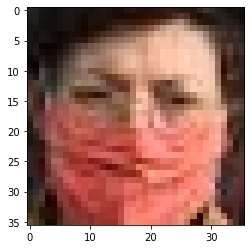

In [25]:
plt.imshow(load_img(example_with_mask))

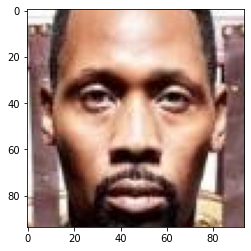

In [26]:
plt.imshow(load_img(example_without_mask))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

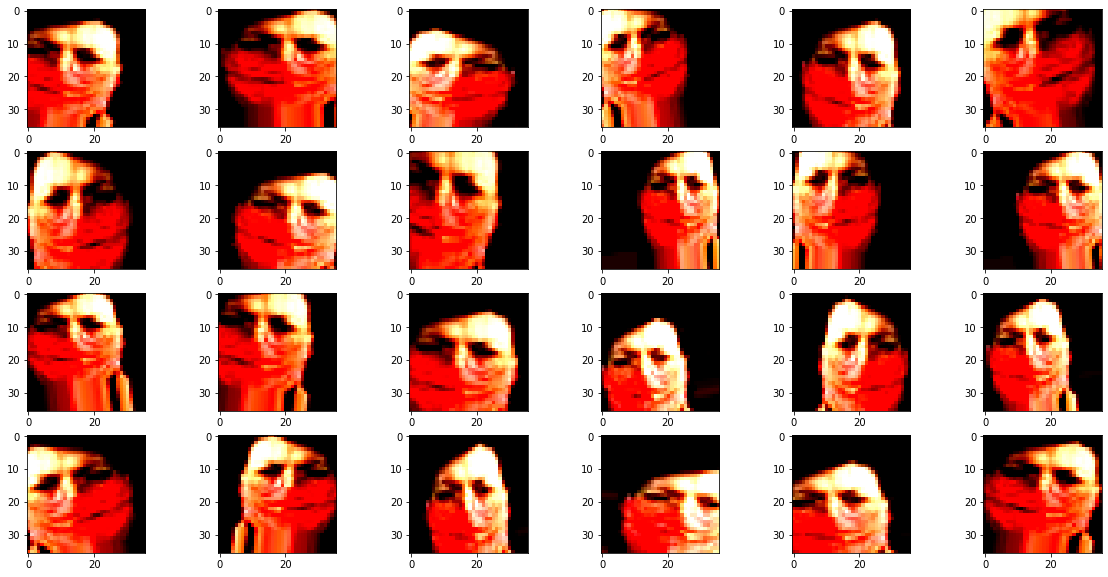

In [27]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                   zoom_range=0.25, 
                                   horizontal_flip=True, 
                                   samplewise_center=True, 
                                   samplewise_std_normalization=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

img = load_img(example_with_mask)
example_aug = img_to_array(img)/255.
#input have 4 axis - need to add extra empty axis for batch
example_aug = example_aug[np.newaxis]
plt.figure(figsize=(20,10))

for i,img in enumerate(train_datagen.flow(example_aug, batch_size=1)):
    plt.subplot(4, 6, i+1)
    #remove empty axis 
    plt.imshow(np.squeeze(img))
    
    if i == 23:
        break
    
plt.show()

In [29]:
train_set = train_datagen.flow_from_directory(directory= path+'/Train', batch_size=BATCH_SIZE, 
                                              class_mode='categorical', target_size=TARGET_SIZE)
validation_set = test_datagen.flow_from_directory(path + '/Validation',target_size=TARGET_SIZE)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [30]:
def craete_model():
    
    denseNet_model = DenseNet201(input_shape=TARGET_SIZE + (3,), weights='imagenet', include_top=False)
    denseNet_model.trainable = False
    
    flatten = Flatten()(denseNet_model.layers[-1].output)
    fc = Dense(units=512, activation='relu')(flatten)
    dropout = Dropout(0.35)(fc)
    output = Dense(2, activation='softmax')(dropout)
   
    model = Model(inputs=denseNet_model.input, outputs=output)
    
    model.summary()
    
    return model


model = craete_model()

74850304/74836368 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
_____________________________

In [31]:
starter_learning_rate = 1e-2
end_learning_rate = 1e-6
decay_steps = 10000
learning_rate = optimizers.schedules.PolynomialDecay(starter_learning_rate,decay_steps,end_learning_rate,power=0.4)

In [32]:
# Define Optimizer, Loss & Metrics

opt = optimizers.Adam(learning_rate=learning_rate)
loss = CategoricalCrossentropy()
met = 'accuracy'

# Compile the Model
model.compile(optimizer=opt, loss=loss, metrics=[met])

In [33]:
my_callbacks = [
                EarlyStopping(monitor='val_accuracy', min_delta=1e-5, patience=5, mode='auto',restore_best_weights=False, verbose=1),
                ModelCheckpoint(filepath='my_model.h5', monitor='accuracy', save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)
]

In [34]:
history = model.fit(train_set,
                    epochs=EPOCHS, steps_per_epoch=len(train_set), # How many mini_batchs we have inside each epoch.
                    validation_data=validation_set,
                    callbacks=[my_callbacks],
                    verbose=1)

print('\n*** Fit is over ***')
model.save('my_model.h5')
#model.save_weights("my_model.h5")

Epoch 1/8
157/157 [==============================] - 126s 528ms/step - loss: 6.6422 - accuracy: 0.9801 - val_loss: 0.3788 - val_accuracy: 0.9950

Epoch 00001: accuracy improved from -inf to 0.98010, saving model to my_model.h5
Epoch 2/8
157/157 [==============================] - 75s 475ms/step - loss: 0.6717 - accuracy: 0.9930 - val_loss: 0.1587 - val_accuracy: 0.9950

Epoch 00002: accuracy improved from 0.98010 to 0.99300, saving model to my_model.h5
Epoch 3/8
157/157 [==============================] - 74s 473ms/step - loss: 0.2504 - accuracy: 0.9943 - val_loss: 0.0124 - val_accuracy: 0.9975

Epoch 00003: accuracy improved from 0.99300 to 0.99430, saving model to my_model.h5
Epoch 4/8
157/157 [==============================] - 75s 475ms/step - loss: 0.0552 - accuracy: 0.9960 - val_loss: 0.0111 - val_accuracy: 0.9962

Epoch 00004: accuracy improved from 0.99430 to 0.99600, saving model to my_model.h5
Epoch 5/8
157/157 [==============================] - 74s 473ms/step - loss: 0.0268 - a

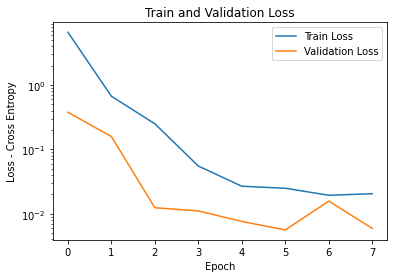

In [35]:
train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])
plt.semilogy(train_loss, label='Train Loss')
plt.semilogy(val_loss, label='Validation Loss')


plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss - Cross Entropy')
plt.title('Train and Validation Loss')


plt.show()

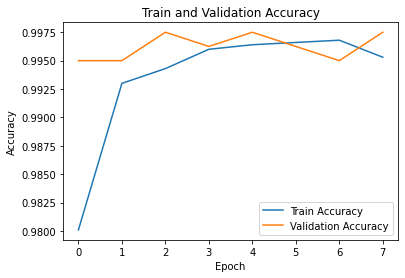

In [36]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch'),
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.show()

In [38]:
test_set = test_datagen.flow_from_directory(path + '/Test',target_size=TARGET_SIZE,shuffle=False)

Found 992 images belonging to 2 classes.


In [39]:
# Model Evaluate 
loss, accuracy = model.evaluate(test_set)
print('Test Accuracy: ', '\033[1m',round(accuracy*100, 2),'%\033[0m')

31/31 [==============================] - 5s 149ms/step - loss: 0.0219 - accuracy: 0.9950
Test Accuracy:   99.5 %


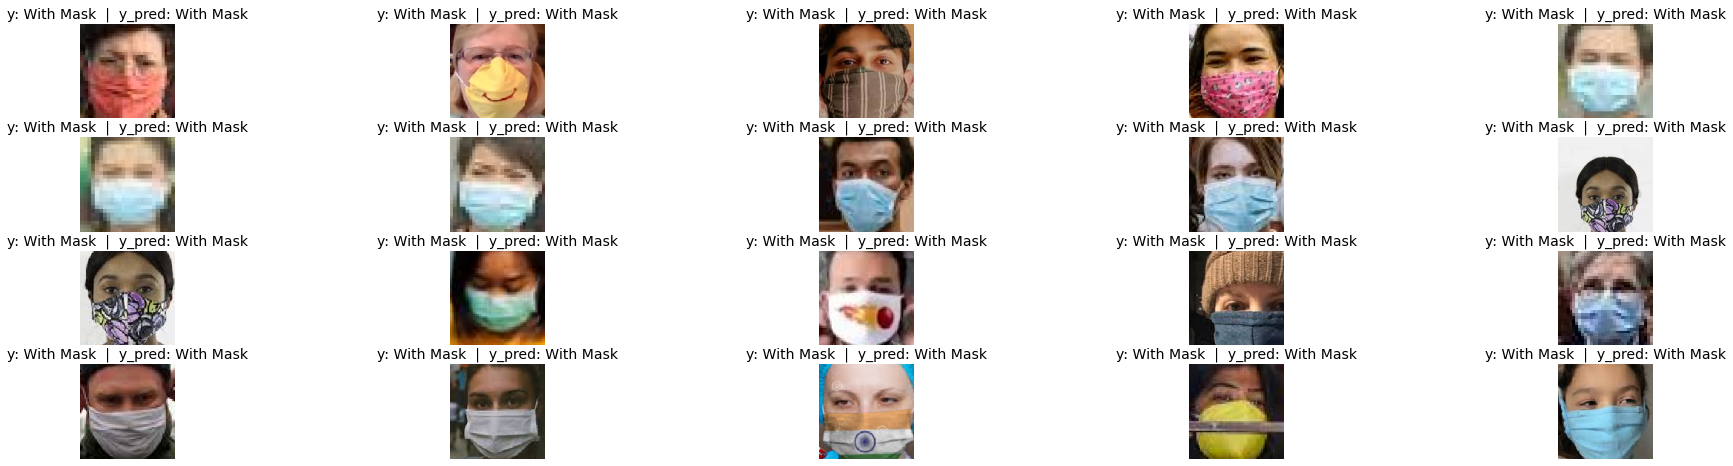

In [40]:
# True Label & Predict of a particular Batch
image, label = test_set.next()
num_imgs = 20
lab_names = ['With Mask','Without Mask ']
images = image[0:num_imgs,:,:,:]
labels = label[0:num_imgs,:]
predict = np.round(model.predict(images))

image_rows = 4
image_col = int(num_imgs/image_rows)

_, axs = plt.subplots(image_rows, image_col, figsize=(32,8))
axs = axs.flatten()

for i in range(num_imgs):
    img = images[i,:,:,:]
    lab = labels[i,:]
    axs[i].imshow(img)
    pred = predict[i]
    axs[i].axis('off')
    lab, pred = np.argmax(lab), np.argmax(pred)
    axs[i].set_title(label = f'y: {lab_names[lab]}  |  y_pred: {lab_names[pred]}', fontsize=14)

plt.show()

In [41]:
y_pred = model.predict(test_set).argmax(axis=-1)
y_test = test_set.classes

Confusion_Matrix = confusion_matrix(y_test,y_pred)

Text(0.5, 1.0, 'Confusion matrix')

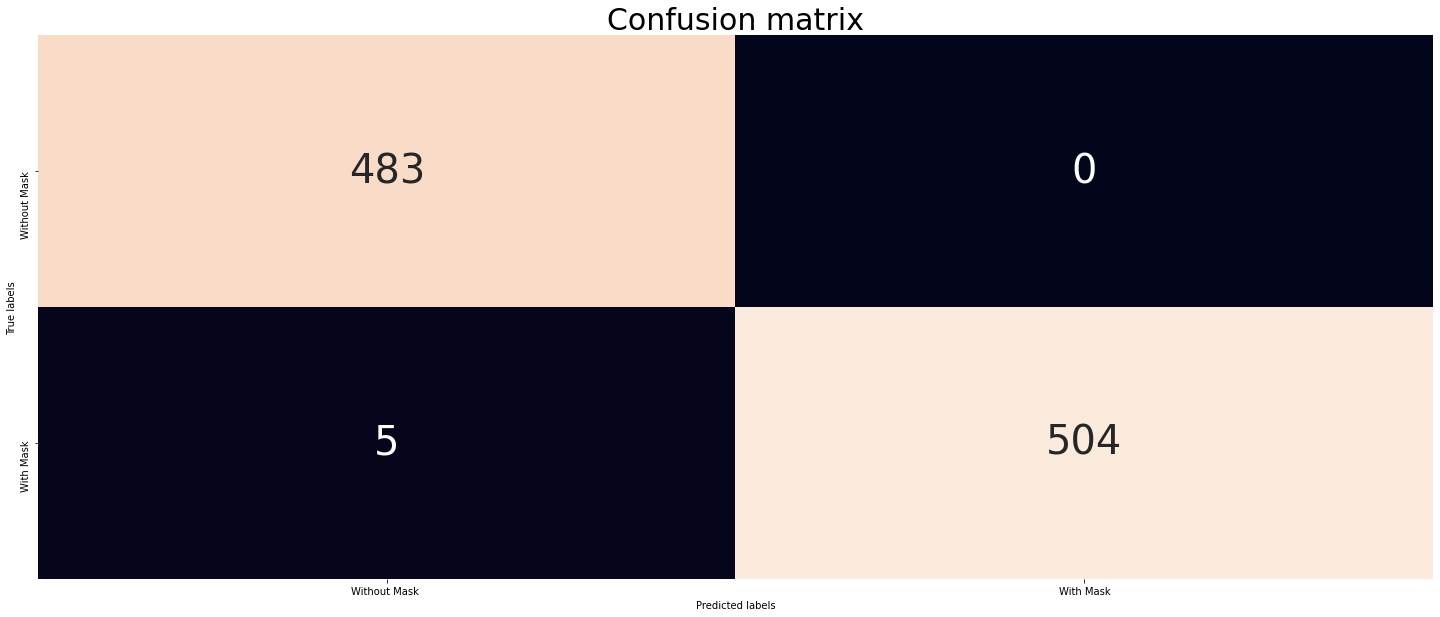

In [42]:
fig, ax = plt.subplots(figsize=(25,10))
sns.heatmap(Confusion_Matrix,xticklabels=CLASSES,yticklabels=CLASSES, ax=ax, annot=True,fmt="1.0f",cbar=False,annot_kws={"size": 40})
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
plt.title("Confusion matrix",fontsize=30)

In [43]:
model.save('my_model.h5')